In [59]:
import os
import re
from itertools import chain

import pycrfsuite
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer

In [19]:
MODEL_PATH = './model/'
MODEL_NAME = 'crf_ner_msra.model'

if not os.path.exists(MODEL_PATH):
    os.mkdir(MODEL_PATH)

MODEL_FILEPATH = os.path.join(MODEL_PATH, MODEL_NAME)

TRAIN_DATAPATH = 'msra_train_bio'
TEST_DATAPATH = 'msra_test_bio'

In [20]:
def load_data(file_path):
    data = []
    labels = []
    sentence = []
    label = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            if len(line.strip()) <= 0:
                data.append(sentence)
                labels.append(label)
                sentence = []
                label = []
            else:
                sentence.append(line.split()[0])
                label.append(line.split()[-1])
    return data, labels

In [21]:
def char2features(sent, i):
    char = sent[i]
    features = [
        'bias',
        'char.lower=' + char.lower(),
    ]
    if i > 0:
        char1 = sent[i - 1]
        features.extend([
            '-1:char.lower=' + char1.lower(),
        ])
    else:
        features.append('BOS')
    if i < len(sent) - 1:
        char1 = sent[i + 1]
        features.extend([
            '+1:char.lower=' + char1.lower(),
        ])
    else:
        features.append('EOS')
    return features

def sent2features(sent):
    return [char2features(sent, i) for i in range(len(sent))]

In [22]:
train_sents, train_labels = load_data(TRAIN_DATAPATH)
test_sents, test_labels = load_data(TEST_DATAPATH)

In [32]:
def train(it=50):
    train_data = [sent2features(s) for s in train_sents]
    trainer = pycrfsuite.Trainer(verbose=True)
    trainer.set_params({
        'c1': 1.0,  # coefficient for L1 penalty
        'c2': 1e-3,  # coefficient for L2 penalty
        'max_iterations': it,  # stop earlier
        # include transitions that are possible, but not observed
        'feature.possible_transitions': True
    })

    print(trainer.params())

    for d, l in zip(train_data, train_labels):
        trainer.append(d, l)
    
    trainer.train(MODEL_FILEPATH)

    print(trainer.logparser.last_iteration)

In [24]:
train(1)

['feature.minfreq', 'feature.possible_states', 'feature.possible_transitions', 'c1', 'c2', 'max_iterations', 'num_memories', 'epsilon', 'period', 'delta', 'linesearch', 'max_linesearch']
Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 0
0....1....2....3....4....5....6....7....8....9....10
Number of features: 35544
Seconds required: 1.831

L-BFGS optimization
c1: 1.000000
c2: 0.001000
num_memories: 6
max_iterations: 1
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

***** Iteration #1 *****
Loss: 2179320.400978
Feature norm: 1.000000
Error norm: 1996013.856465
Active features: 32174
Line search trials: 1
Line search step: 0.000000
Seconds required for this iteration: 2.538

L-BFGS terminated with the maximum number of iterations
Total seconds required for training: 2.540

Storing the model
Number of active features: 32174 (35544)
Number of active attributes: 12696 (14295)
N

In [28]:
def predict():
    tagger = pycrfsuite.Tagger()
    tagger.open(MODEL_FILEPATH)
    example_sent = test_sents[3]
    print(' '.join(example_sent), end='\n\n')
    print("Predicted:", ' '.join(tagger.tag(sent2features(example_sent))))
    print("Correct:  ", ' '.join(test_labels[3]))

In [29]:
predict()

在 此 ， 中 共 中 央 谨 向 致 公 党 中 央 以 及 全 体 成 员 致 以 崇 高 的 敬 意 ！

Predicted: O O O O O O O O O O O O O O O O O O O O O O O O O O O O
Correct:   O O O B-ORG I-ORG I-ORG I-ORG O O B-ORG I-ORG I-ORG I-ORG I-ORG O O O O O O O O O O O O O O


In [30]:
def predict_by_sent(sent):
    tagger = pycrfsuite.Tagger()
    tagger.open(MODEL_FILEPATH)
    return tagger.tag(sent2features(sent))

In [40]:
def bio_classification_report(y_true, y_pred):
    lb = LabelBinarizer()
    y_true_combined = lb.fit_transform(list(chain.from_iterable(y_true)))
    y_pred_combined = lb.transform(list(chain.from_iterable(y_pred)))

    tagset = set(lb.classes_) - {'O'}
    tagset = sorted(tagset, key=lambda tag: tag.split('-', 1)[::-1])
    class_indices = {cls: idx for idx, cls in enumerate(lb.classes_)}

    return classification_report(
        y_true_combined,
        y_pred_combined,
        labels=[class_indices[cls] for cls in tagset],
        target_names=tagset,
    )


def evaluate():
    tagger = pycrfsuite.Tagger()
    tagger.open(MODEL_FILEPATH)
    X_test = [sent2features(s) for s in test_sents]
    y_test = test_labels
    y_pred = [tagger.tag(xseq) for xseq in X_test]
    print(bio_classification_report(y_test, y_pred))

In [31]:
predict_by_sent('香港，你好。')

['O', 'O', 'O', 'O', 'O', 'O']

In [ ]:
train(50)
"""
['feature.minfreq', 'feature.possible_states', 'feature.possible_transitions', 'c1', 'c2', 'max_iterations', 'num_memories', 'epsilon', 'period', 'delta', 'linesearch', 'max_linesearch']
Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 35577
Seconds required: 1.380

L-BFGS optimization
c1: 1.000000
c2: 0.001000
num_memories: 6
max_iterations: 50
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20
"""

In [34]:
predict_by_sent('香港，你好。')

['B-LOC', 'I-LOC', 'O', 'O', 'O', 'O']

In [ ]:
train(5000)
"""
['feature.minfreq', 'feature.possible_states', 'feature.possible_transitions', 'c1', 'c2', 'max_iterations', 'num_memories', 'epsilon', 'period', 'delta', 'linesearch', 'max_linesearch']
Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 35577
Seconds required: 1.354

L-BFGS optimization
c1: 1.000000
c2: 0.001000
num_memories: 6
max_iterations: 5000
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20


-------

L-BFGS terminated with the stopping criteria
Total seconds required for training: 1233.775

Storing the model
Number of active features: 13212 (35577)
Number of active attributes: 5874 (14295)
Number of active labels: 8 (8)
Writing labels
Writing attributes
Writing feature references for transitions
Writing feature references for attributes
Seconds required: 0.009

{'time': 1.223, 'linesearch_trials': 1, 'scores': {}, 'num': 979, 'linesearch_step': 1.0, 
'active_features': 13212, 'feature_norm': 212.318736, 'error_norm': 96.631076, 'loss': 73610.56687}
"""

In [74]:
losses = []
feature_norms = []
error_norms = []
activate_features = []
line_search_trailses = []
line_search_steps = []
seconds_required_for_this_iterations = []

with open('train_process_output', 'r', encoding='utf-8') as f:
    texts = f.readlines()

In [51]:
iters = re.findall(r'.*?Iteration\s#(\d+).*?', ''.join(texts))
iters = [int(x) for x in iters]

In [52]:
losses = re.findall(r'Loss:\s(.*?)\s', ''.join(texts))
losses = [float(x) for x in losses]

In [53]:
feature_norms = re.findall(r'Feature norm:\s(.*?)\s', ''.join(texts))
feature_norms = [float(x) for x in feature_norms]

In [54]:
error_norms = re.findall(r'Error norm:\s(.*?)\s', ''.join(texts))
error_norms = [float(x) for x in error_norms]

In [55]:
activate_features = re.findall(r'Active features:\s(.*?)\s', ''.join(texts))
activate_features = [int(x) for x in activate_features]

In [56]:
line_search_trailses = re.findall(r'Line search trials:\s(\d+)\s', ''.join(texts))
line_search_trailses = [int(x) for x in line_search_trailses]

In [57]:
line_search_steps = re.findall(r'Line search step:\s(.*?)\s', ''.join(texts))
line_search_steps = [float(x) for x in line_search_steps]

In [76]:
seconds_required_for_this_iterations = re.findall(r'Seconds required for this iteration:\s(.*?)\s', ''.join(texts))
seconds_required_for_this_iterations = [float(x) for x in seconds_required_for_this_iterations]

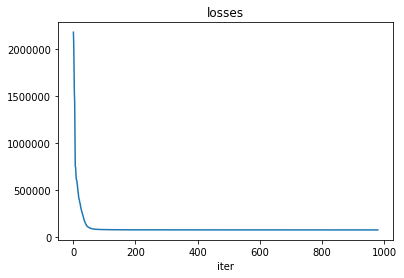

In [62]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(iters, losses)
ax1.set_title('losses')
ax1.set_xlabel('iter')
plt.show()

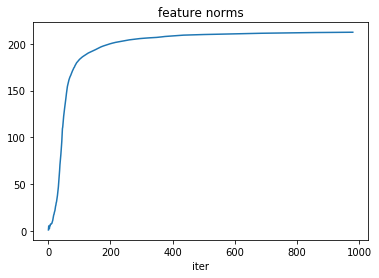

In [63]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(iters, feature_norms)
ax1.set_title('feature norms')
ax1.set_xlabel('iter')
plt.show()

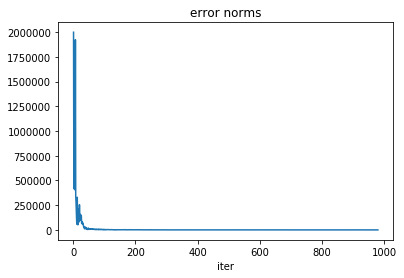

In [66]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(iters, error_norms)
ax1.set_title('error norms')
ax1.set_xlabel('iter')
plt.show()

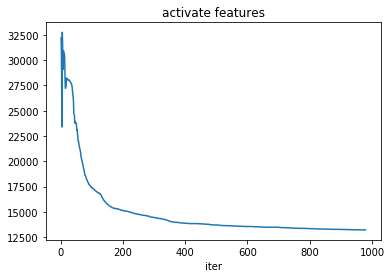

In [67]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(iters, activate_features)
ax1.set_title('activate features')
ax1.set_xlabel('iter')
plt.show()

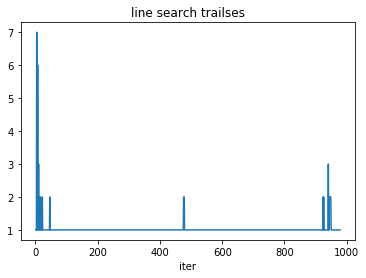

In [68]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(iters, line_search_trailses)
ax1.set_title('line search trailses')
ax1.set_xlabel('iter')
plt.show()

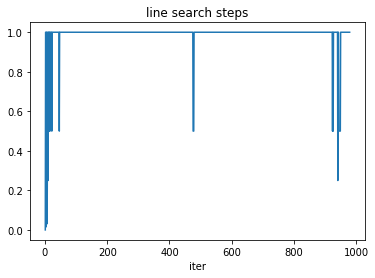

In [69]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(iters, line_search_steps)
ax1.set_title('line search steps')
ax1.set_xlabel('iter')
plt.show()

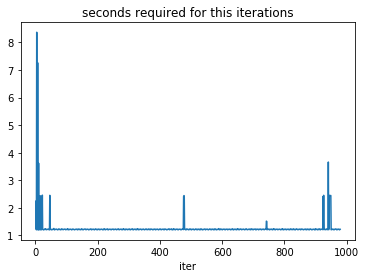

In [77]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(iters, seconds_required_for_this_iterations)
ax1.set_title('seconds required for this iterations')
ax1.set_xlabel('iter')
plt.show()

In [41]:
evaluate()

              precision    recall  f1-score   support

       B-LOC       0.90      0.82      0.86      2886
       I-LOC       0.86      0.74      0.80      4405
       B-ORG       0.78      0.69      0.73      1331
       I-ORG       0.81      0.76      0.78      5646
       B-PER       0.93      0.75      0.83      1973
       I-PER       0.86      0.88      0.87      3851

   micro avg       0.85      0.78      0.82     20092
   macro avg       0.86      0.78      0.81     20092
weighted avg       0.85      0.78      0.82     20092
 samples avg       0.09      0.09      0.09     20092



/data/tzhu/.envs/nlp-py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/data/tzhu/.envs/nlp-py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)
